In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.nn as nn
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import matplotlib.pyplot as plt
import torch.optim as optimizer
import torch.nn.functional as F
import timm

c:\Users\dimia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Εισαγωγή βιβλιοθηκών για τυχαίους αριθμούς
import random
import numpy as np

# Συνάρτηση για ορισμό σταθερού seed σε όλες τις βιβλιοθήκες
def set_seed(seed=42):
    random.seed(seed)               # Ορισμός seed για τη βιβλιοθήκη random
    np.random.seed(seed)            # Ορισμός seed για τη βιβλιοθήκη numpy
    torch.manual_seed(seed)         # Ορισμός seed για CPU tensors του PyTorch
    torch.cuda.manual_seed(seed)    # Ορισμός seed για GPU tensors
    torch.cuda.manual_seed_all(seed)# Ορισμός seed για όλα τα GPU tensors (multi-GPU)

    # Διασφαλίζει deterministic συμπεριφορά σε CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Κλήση της συνάρτησης για να σταθεροποιήσουμε τα αποτελέσματα
set_seed(42)


In [3]:
# Εισαγωγή εργαλείων για DataLoader και μετασχηματισμούς εικόνων
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import BloodMNIST

# Ορισμός μετασχηματισμών για preprocessing των εικόνων
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Αλλαγή μεγέθους εικόνων σε 224x224 για ResNet
    transforms.ToTensor(),                # Μετατροπή εικόνας σε PyTorch tensor (C, H, W)
    transforms.Normalize(                  # Κανονικοποίηση με mean και std του ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Φόρτωση του BloodMNIST dataset με τους παραπάνω μετασχηματισμούς
train_dataset = BloodMNIST(split="train", download=True, transform=transform)
val_dataset   = BloodMNIST(split="val",   download=True, transform=transform)
test_dataset  = BloodMNIST(split="test",  download=True, transform=transform)

# Δημιουργία DataLoaders για εύκολη επεξεργασία batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle για τυχαία σειρά κατά την εκπαίδευση
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False) # Shuffle=False για συνεπή validation
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False) # Shuffle=False για συνεπή testing
# αλλαγή batch_size σε 16 για fine tuning


In [4]:
# Φόρτωση ενός pretrained DeiT (Data-efficient Image Transformer) μικρού μοντέλου
import timm
model = timm.models.deit_tiny_patch16_224(pretrained=True)  # pretrained στο ImageNet
model.to(device=device)  # Μεταφορά μοντέλου σε GPU/CPU

# Αντικατάσταση του τελικού classification head για 8 κλάσεις (BloodMNIST)
model.head = nn.Linear(192, 8)  # 192 features εισόδου -> 8 κλάσεις εξόδου

# Εμφάνιση του μοντέλου
model


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [5]:
# feature extraction του DeiT μοντέλου
# Δηλαδή δεν θα ενημερώνονται κατά την εκπαίδευση παράμετροι πέρα του fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Αποπάγωμα μόνο του νέου classification head
# Μόνο αυτό το layer θα εκπαιδευτεί για τις 8 κλάσεις BloodMNIST
for param2 in model.head.parameters():
    param2.requires_grad = True


In [6]:
# Ορισμός Adam optimizer μόνο για το classification head του DeiT
optim_adam = optimizer.Adam(model.head.parameters(), lr=0.001)  # Μόνο τα unfrozen weights θα ενημερωθούν

# Υπερπαράμετροι εκπαίδευσης
epochs = 14        # Αριθμός εποχών
batch_size = 32    # Μέγεθος batch

# Συνάρτηση κόστους για multi-class classification
criterion = nn.CrossEntropyLoss()

# Scheduler που μειώνει το learning rate όταν η απώλεια σταματά να βελτιώνεται
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer=optim_adam,  # Σχετίζεται με τον optimizer
    mode='min',            # Παρακολουθούμε την απώλεια (loss)
    factor=0.7,            # Μείωση του learning rate κατά 30% όταν δεν υπάρχει βελτίωση
    patience=3,            # Περιμένει 3 εποχές πριν μειώσει το learning rate
    threshold=0.007,       # Κατώφλι αλλαγής για να θεωρηθεί βελτίωση
    min_lr=1e-6            # Ελάχιστο learning rate
)


In [7]:
# Φόρτωση ενός δεύτερου pretrained DeiT tiny μοντέλου
model2 = timm.models.deit_tiny_patch16_224(pretrained=True)
model2.to(device=device)  # Μεταφορά σε GPU/CPU

# Αντικατάσταση του τελικού classification head για 8 κλάσεις BloodMNIST
model2.head = nn.Linear(192, 8)

# Προβολή του 12ου transformer block (blocks[11])
# Κάθε DeiT tiny έχει 12 blocks, ο δείκτης 11 αναφέρεται στο τελευταίο block
model2.blocks[11]


Block(
  (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=192, out_features=576, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=192, out_features=192, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=768, out_features=192, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [8]:
# Fine-tuning του DeiT μοντέλου
# 1. Πάγουμε όλα τα pretrained weights (κανένα layer δεν αλλάζει)
for param in model2.parameters():
    param.requires_grad = False

# 2. Αποπάγωμα του τελευταίου transformer block (blocks[11])
#    Μόνο αυτό το block θα προσαρμοστεί στα νέα δεδομένα
for param3 in model2.blocks[11].parameters():
    param3.requires_grad = True

# 3. Αποπάγωμα του νέου classification head
#    Το head θα μάθει να προβλέπει τις 8 κλάσεις BloodMNIST
for param2 in model2.head.parameters():
    param2.requires_grad = True


In [9]:
# Ορισμός Adam optimizer για fine-tuning του model2 (DeiT)
# Περιλαμβάνει μόνο τα unfrozen layers (τελευταίο block + head)
optim_adam2 = optimizer.Adam(
    model2.parameters(),    # Θα ενημερώσει μόνο τα αποπαγωμένα weights
    lr=0.0001,              # Πολύ χαμηλό learning rate για σταθερό fine-tuning
    weight_decay=1e-6,      # L2 regularization για αποφυγή overfitting
    betas=(0.9, 0.9995)     # Σταθερές Adam για momentum
)

# Υπερπαράμετροι εκπαίδευσης
epochs2 = 8        # Λιγότερες εποχές λόγω fine-tuning
batch_size2 = 16   # Μικρότερο batch size για πιο αργή και σταθερή ενημέρωση

# Συνάρτηση κόστους για multi-class classification
criterion2 = nn.CrossEntropyLoss()

# Scheduler που μειώνει δυναμικά το learning rate όταν η απώλεια σταματά να βελτιώνεται
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler2 = ReduceLROnPlateau(
    optimizer=optim_adam2,
    mode='min',        # Παρακολουθούμε τη μείωση της απώλειας
    factor=0.5,        # Μείωση lr στο μισό όταν δεν υπάρχει βελτίωση
    patience=2,        # Περιμένει 2 εποχές πριν μειώσει το lr
    threshold=0.01,    # Κατώφλι βελτίωσης
    min_lr=1e-6        # Ελάχιστο learning rate
)


In [10]:
def training_loop(Model, Optimizer, train_loader, val_loader, epochs, criterion, scheduling=None):
    """
    Training loop για PyTorch μοντέλα με DataLoader.
    Διατηρεί λογική training/validation accuracy και loss.
    """
    history = []              # training loss
    val_loss_history = []     # validation loss
    accuracys_training = []   # training accuracy
    accuracys_validation = [] # validation accuracy

    for epoch in range(epochs):
        Model.train()  # training mode
        total_loss = 0
        total_samples = 0
        correct_train = 0

        # ------------------ Training ------------------
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.squeeze()  
            outputs = Model(X_batch)
            loss = criterion(outputs, y_batch)
            
            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            total_samples += X_batch.size(0)
            correct_train += (outputs.argmax(1) == y_batch).sum().item()

        avg_train_loss = total_loss / total_samples
        train_accuracy = correct_train / total_samples

        # ------------------ Validation ------------------
        Model.eval()
        total_val_loss = 0
        total_val_samples = 0
        correct_val = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.squeeze()  
                outputs = Model(X_batch)

                loss = criterion(outputs, y_batch)

                total_val_loss += loss.item() * X_batch.size(0)
                total_val_samples += X_batch.size(0)
                correct_val += (outputs.argmax(1) == y_batch).sum().item()

        avg_val_loss = total_val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples

        if scheduling is not None:
            scheduling.step(avg_val_loss)

        # Save history
        history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        accuracys_training.append(train_accuracy)
        accuracys_validation.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return history, val_loss_history, accuracys_training, accuracys_validation


In [11]:
history2,val_loss2,accracys_training2,accracys_validation2=training_loop(Model=model2,Optimizer=optim_adam2,train_loader=train_loader,val_loader=val_loader,epochs=epochs2,criterion=criterion2,scheduling=scheduler2)

Epoch [1/8] Train Loss: 0.8605, Val Loss: 0.5216, Train Acc: 0.7021, Val Acc: 0.8178
Epoch [2/8] Train Loss: 0.4238, Val Loss: 0.3858, Train Acc: 0.8517, Val Acc: 0.8715
Epoch [3/8] Train Loss: 0.3493, Val Loss: 0.3480, Train Acc: 0.8745, Val Acc: 0.8768
Epoch [4/8] Train Loss: 0.2960, Val Loss: 0.3163, Train Acc: 0.8957, Val Acc: 0.8966
Epoch [5/8] Train Loss: 0.2565, Val Loss: 0.3045, Train Acc: 0.9095, Val Acc: 0.9036
Epoch [6/8] Train Loss: 0.2259, Val Loss: 0.2942, Train Acc: 0.9216, Val Acc: 0.8919
Epoch [7/8] Train Loss: 0.1997, Val Loss: 0.3090, Train Acc: 0.9303, Val Acc: 0.8919
Epoch [8/8] Train Loss: 0.1679, Val Loss: 0.2831, Train Acc: 0.9411, Val Acc: 0.9030


In [12]:
history,val_loss,accracys_training,accracys_validation=training_loop(Model=model,Optimizer=optim_adam,train_loader=train_loader,val_loader=val_loader,epochs=epochs,criterion=criterion,scheduling=scheduler)

Epoch [1/14] Train Loss: 1.0374, Val Loss: 0.7432, Train Acc: 0.6640, Val Acc: 0.7617
Epoch [2/14] Train Loss: 0.6638, Val Loss: 0.6172, Train Acc: 0.7841, Val Acc: 0.8020
Epoch [3/14] Train Loss: 0.5762, Val Loss: 0.5712, Train Acc: 0.8124, Val Acc: 0.8131
Epoch [4/14] Train Loss: 0.5332, Val Loss: 0.5455, Train Acc: 0.8216, Val Acc: 0.8172
Epoch [5/14] Train Loss: 0.5026, Val Loss: 0.5147, Train Acc: 0.8323, Val Acc: 0.8289
Epoch [6/14] Train Loss: 0.4825, Val Loss: 0.4978, Train Acc: 0.8358, Val Acc: 0.8324
Epoch [7/14] Train Loss: 0.4677, Val Loss: 0.4918, Train Acc: 0.8396, Val Acc: 0.8294
Epoch [8/14] Train Loss: 0.4534, Val Loss: 0.4814, Train Acc: 0.8459, Val Acc: 0.8364
Epoch [9/14] Train Loss: 0.4435, Val Loss: 0.4663, Train Acc: 0.8492, Val Acc: 0.8411
Epoch [10/14] Train Loss: 0.4321, Val Loss: 0.4729, Train Acc: 0.8532, Val Acc: 0.8353
Epoch [11/14] Train Loss: 0.4259, Val Loss: 0.4649, Train Acc: 0.8529, Val Acc: 0.8324
Epoch [12/14] Train Loss: 0.4204, Val Loss: 0.4629, 

In [13]:
def metrics(model, test_loader, device):
    # Θέτουμε το μοντέλο σε evaluation mode
    # (απενεργοποιεί dropout, batchnorm updates κλπ)
    model.eval()

    # Αριθμός κλάσεων του BloodMNIST
    num_classes = 8

    # Αρχικοποίηση confusion matrix
    # Γραμμές: πραγματικές κλάσεις
    # Στήλες: προβλεπόμενες κλάσεις
    confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)

    # Μετρητές για συνολική ακρίβεια
    correct = 0  # σωστές προβλέψεις
    total = 0    # συνολικά δείγματα

    # Δεν υπολογίζουμε gradients (εξοικονόμηση μνήμης και ταχύτητα)
    with torch.no_grad():
        # Επεξεργασία του test set batch-by-batch
        for X, y in test_loader:
            # Μεταφορά δεδομένων στη συσκευή (GPU ή CPU)
            X = X.to(device)
            y = y[:, 0].to(device)  # labels από shape (N,1) → (N,)

            # Forward pass: προβλέψεις του μοντέλου
            outputs = model(X)

            # Επιλογή κλάσης με τη μέγιστη πιθανότητα
            preds = outputs.argmax(dim=1)

            # Υπολογισμός συνολικής ακρίβειας
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Ενημέρωση confusion matrix
            # Για κάθε δείγμα:
            #   true label = y
            #   predicted label = preds
            for t, p in zip(y, preds):
                confusion_matrix[t, p] += 1

    # Τελική ακρίβεια test set
    accuracy = correct / total

    # Επιστρέφουμε:
    # - accuracy (float)
    # - confusion matrix σε numpy array (για plotting)
    return accuracy, confusion_matrix.cpu().numpy()


Test Accuracy: 90.18%


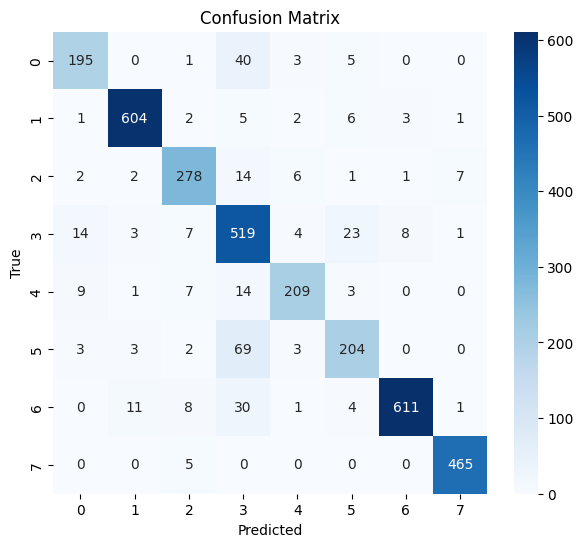

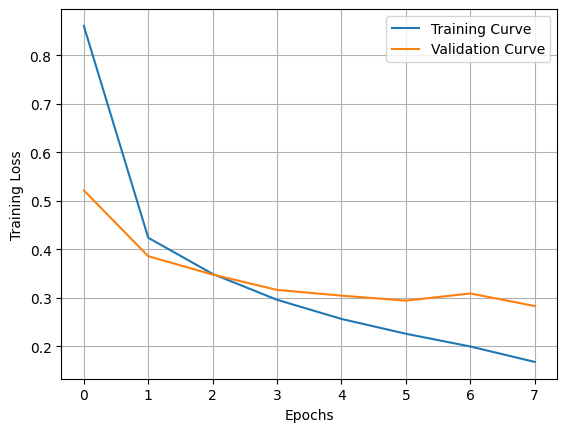

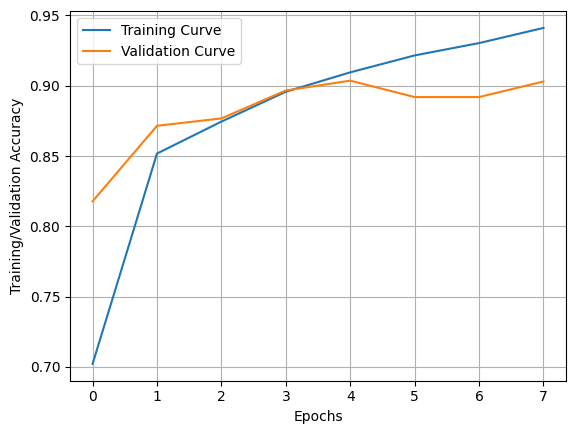

In [14]:
import seaborn as sns 


# Υπολογισμός metrics (accuracy, confusion matrix) για το μοντέλο
accuracy_score2, cm2 = metrics(model2, test_loader, device)
print(f"Test Accuracy: {accuracy_score2 * 100:.2f}%")  # Εκτύπωση συνολικής ακρίβειας

# Σχεδίαση confusion matrix με heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")  # Annot=True δείχνει τους αριθμούς στο κάθε κελί
plt.xlabel("Predicted")  # Ετικέτα στον άξονα x
plt.ylabel("True")       # Ετικέτα στον άξονα y
plt.title("Confusion Matrix")  # Τίτλος γραφήματος
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(history2)      # Σειρά με training loss
plt.plot(val_loss2)     # Σειρά με validation loss
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure()
plt.plot(accracys_training2)      # Σειρά με training accuracy
plt.plot(accracys_validation2)    # Σειρά με validation accuracy
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training/Validation Accuracy')
plt.grid(True)
plt.show()


Test Accuracy: 85.03%


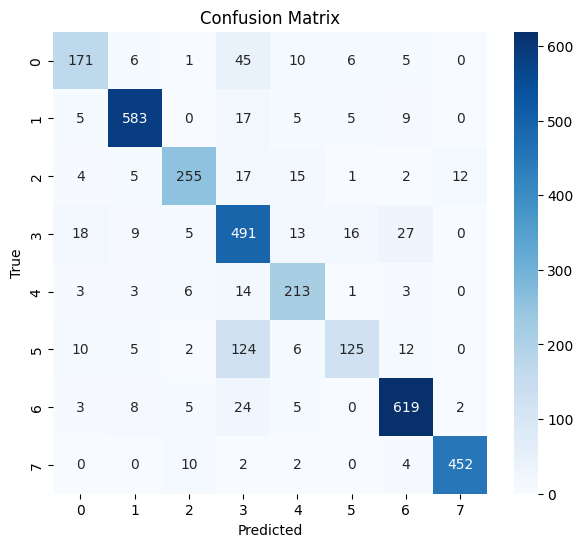

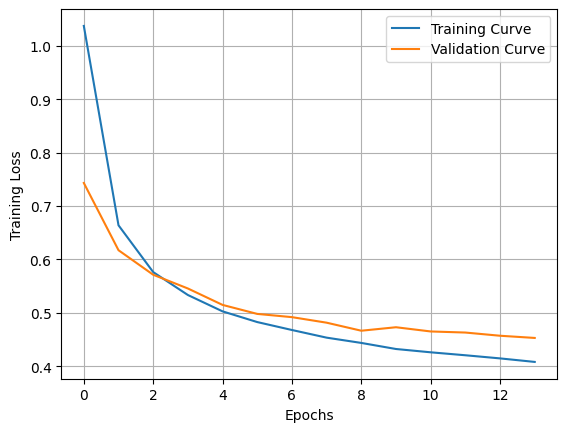

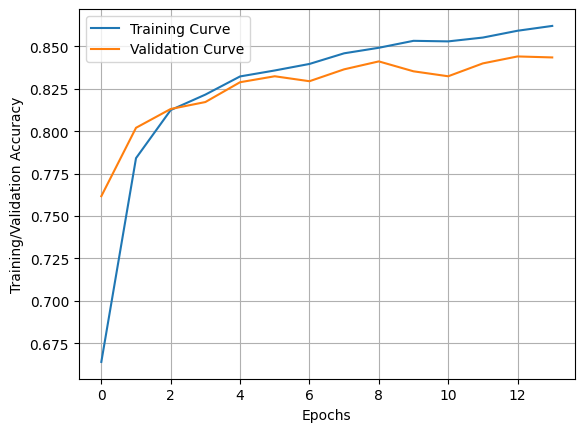

In [15]:
# Υπολογισμός metrics (accuracy, confusion matrix) για το μοντέλο 
accuracy_score, cm = metrics(model, test_loader, device)
print(f"Test Accuracy: {accuracy_score * 100:.2f}%")  # Εκτύπωση συνολικής ακρίβειας

# Σχεδίαση confusion matrix με heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Annot=True δείχνει τους αριθμούς στο κάθε κελί
plt.xlabel("Predicted")  # Ετικέτα στον άξονα x
plt.ylabel("True")       # Ετικέτα στον άξονα y
plt.title("Confusion Matrix")  # Τίτλος γραφήματος
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(history)      # Σειρά με training loss
plt.plot(val_loss)     # Σειρά με validation loss
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure()
plt.plot(accracys_training)      # Σειρά με training accuracy
plt.plot(accracys_validation)    # Σειρά με validation accuracy
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training/Validation Accuracy')
plt.grid(True)
plt.show()
